In [9]:
import matplotlib.pyplot as plt
import numpy as np
from autots import AutoTS
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import plotly.express as px  # to plot the time series plot
from sklearn import metrics  # for the evaluation
from foursquareAPI import get_poi
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.seasonal import seasonal_decompose
from timeit import default_timer as timer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df


,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [5]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync


In [6]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)

    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)

    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    # # Print entire dataframe
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     print(parking_sync)

    parkings[name] = parking_sync  # Save the synced data frame to dict

    # plt.plot(parking_sync["Zasedenost"])
    # plt.gcf().autofmt_xdate()
    # plt.xlabel("Datum")
    # plt.ylabel("Stevilo zasedenih mest")
    # plt.title(f"Parkirisce: {name}")
    # plt.show()

parkings


{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
 date                                                               
 2022-03-04 09:31:53         0.0          80               0.0000   
 2022-03-04 09:41:53         0.0          80               0.0000   
 2022-03-04 09:51:53         0.0          80               0.0000   
 2022-03-04 10:01:53         0.0          80               0.0000   
 2022-03-04 10:11:53         0.0          80               0.0000   
 ...                         ...         ...                  ...   
 2022-05-10 03:51:53        17.0          80               0.2125   
 2022-05-10 04:01:53        16.0          80               0.2000   
 2022-05-10 04:11:53        15.0          80               0.1875   
 2022-05-10 04:21:53        16.0          80               0.2000   
 2022-05-10 04:31:53        17.0          80               0.2125   
 
                      Restaurant_score  Art_score  Coffee_score  Bar_score  
 date         

In [7]:
first_parking = parkings[next(iter(parkings))]
n_rows = len(first_parking)
train_size = int(n_rows * 0.75)

train = first_parking[:train_size]
test = first_parking[train_size:]

exog_train = train[["Restaurant_score", "Art_score", "Coffee_score", "Bar_score"]]
exog_test = test[["Restaurant_score", "Art_score", "Coffee_score", "Bar_score"]]
y = train[["Zasedenost"]]


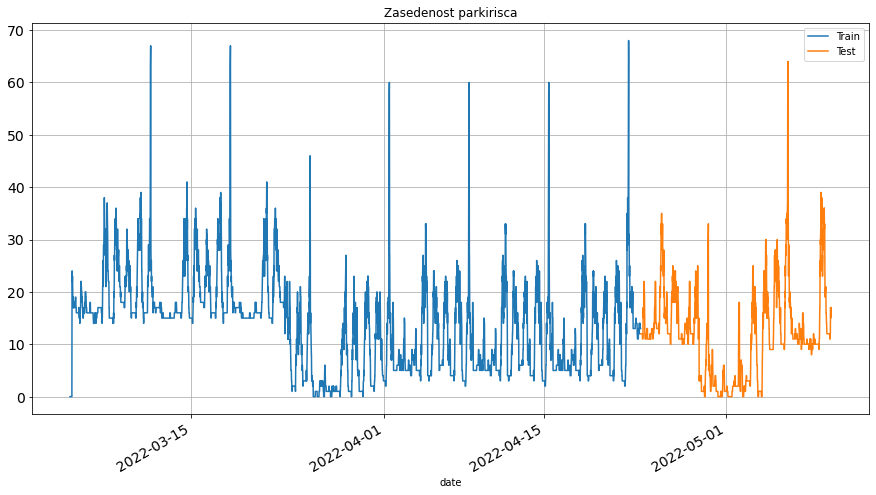

In [8]:
train.Zasedenost.plot(figsize=(15, 8), title='Zasedenost parkirisca', fontsize=14, label='Train')
test.Zasedenost.plot(figsize=(15, 8), title='Zasedenost parkirisca', fontsize=14, label='Test')
plt.legend()
plt.grid()
plt.show()


In [13]:
train["Date"] = train.index
train

,Zasedenost,Kapaciteta,Procent_zasedenosti,Restaurant_score,Art_score,Coffee_score,Bar_score,Date
date,,,,,,,,
2022-03-04 09:31:53,0.0,80,0.0000,19.0,0,0,0,2022-03-04 09:31:53
2022-03-04 09:41:53,0.0,80,0.0000,19.0,0,0,0,2022-03-04 09:41:53
2022-03-04 09:51:53,0.0,80,0.0000,19.0,0,0,0,2022-03-04 09:51:53
2022-03-04 10:01:53,0.0,80,0.0000,19.0,0,0,0,2022-03-04 10:01:53
2022-03-04 10:11:53,0.0,80,0.0000,19.0,0,0,0,2022-03-04 10:11:53
...,...,...,...,...,...,...,...,...
2022-04-23 11:01:53,13.0,80,0.1625,19.0,0,0,0,2022-04-23 11:01:53
2022-04-23 11:11:53,13.0,80,0.1625,19.0,0,0,0,2022-04-23 11:11:53
2022-04-23 11:21:53,13.0,80,0.1625,19.0,0,0,0,2022-04-23 11:21:53


In [14]:
model = AutoTS()
model.fit(df=train, date_col="Date", value_col="Zasedenost")


Inferred frequency is: 10T
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model DatepartRegression in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Epoch 1/50
225/225 [==============================] - 3s 2ms/step - loss: 0.3001
Epoch 2/50
225/225 [==============================] - 0s 2ms/step - loss: 0.1939
Epoch 3/50
225/225 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 4/50
225/225 [==============================] - 0s 2ms/step - loss: 0.1601
Epoch 5/50
225/225 [==============================] - 0s 2ms/step - loss: 0.1496
Epoch 6/50
225/225 [==============================] - 0s 2ms/step - loss: 0.1518
Epoch 7/50
225

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 770 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 420 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Model Number: 264 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 264: DatepartRegression
Model Number: 265 with model DatepartRegression in generation 2 of 10
Model Number: 266 with model ETS in generation 2 of 10
Model Number: 267 with model ETS in generation 2 of 10
Model Number: 268 with model ETS in generation 2 of 10
Model Number: 269 with model ETS in generation 2 of 10
Model Number: 270 with model MultivariateRegression in generation 2 of 10
Model Number: 271 with model MultivariateRegression in generation 2 of 10
Template Eval Error: ValueError("loss='poisson' requires non-negative y and sum(y) > 0.") in model 271: MultivariateRegression
Model Number: 272 with model MultivariateRegression in generation 2 of 10
Model Number: 273 with model MultivariateRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but n

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 355 with model DatepartRegression in generation 3 of 10


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 356 with model DatepartRegression in generation 3 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 356: DatepartRegression
Model Number: 357 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 357: GluonTS
Model Number: 358 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 358: GluonTS
Model Number: 359 with model GluonTS in generation 3 of 10
Template Eval Error: Exception('Transformer STLFilter failed on fit') in model 359: GluonTS
Model Number: 360 with model GluonTS in generation 3 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 360: GluonTS
Model Number: 361 with model VAR in generation 3 of 10
Template

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 491 with model MultivariateRegression in generation 5 of 10
Template Eval Error: ModuleNotFoundError("No module named 'lightgbm'") in model 491: MultivariateRegression
Model Number: 492 with model MultivariateRegression in generation 5 of 10
Model Number: 493 with model MultivariateRegression in generation 5 of 10
Model Number: 494 with model MultivariateRegression in generation 5 of 10
Model Number: 495 with model ARDL in generation 5 of 10
Model Number: 496 with model ARDL in generation 5 of 10
Model Number: 497 with model ARDL in generation 5 of 10
Model Number: 498 with model ARDL in generation 5 of 10
Model Number: 499 with model DatepartRegression in generation 5 of 10
Template Eval Error: ValueError('Failed to convert a NumPy array to a Tensor (Unsupported object type int).') in model 499: DatepartRegression
Model Number: 500 with model DatepartRegression in generation 5 of 10
Model Number: 501 with model DatepartRegression in generation 5 of 10
Template Eval Error

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 656 with model DatepartRegression in generation 7 of 10
Model Number: 657 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 657: GluonTS
Model Number: 658 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 658: GluonTS
Model Number: 659 with model GluonTS in generation 7 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 659: GluonTS
Model Number: 660 with model GluonTS in generation 7 of 10
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 660: GluonTS
Model Number: 661 with model VAR in generation 7 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 661: VAR
Model Number: 662 with model VAR in g

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 807 with model DatepartRegression in generation 9 of 10
Model Number: 808 with model DatepartRegression in generation 9 of 10
Model Number: 809 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 809: GluonTS
Model Number: 810 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 810: GluonTS
Model Number: 811 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 811: GluonTS
Model Number: 812 with model GluonTS in generation 9 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 812: GluonTS
Model Number: 813 with model VAR in generation 9 of 10
Template Eval

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'Dist', 'model_count': 2, 'model_metric': 'smape', 'models': {'644c0aa687f5375dbc4b490118579bea': {'Model': 'AverageValueNaive', 'ModelParameters': '{"method": "Mean"}', 'TransformationParameters': '{"fillna": "mean", "transformations": {"0": "ClipOutliers", "1": "QuantileTransformer", "2": "DifferencedTransformer"}, "transformation_params": {"0": {"method": "clip", "std_threshold": 3, "fillna": null}, "1": {"output_distribution": "uniform", "n_quantiles": 1000}, "2": {}}}'}, '574fa507eeee5a9fa026c1c7c159603c': {'Model': 'UnivariateMotif', 'ModelParameters': '{"window": 7, "point_method": "weighted_mean", "distance_metric": "jaccard", "k": 100, "max_windows": 1000}', 'TransformationParameters': '{"fillna": "rolling_mean_24", "transformations": {"0": "QuantileTransformer", "1": "DifferencedTransformer", "2": "MinMaxScaler", "3": "PowerTransformer"}, "transformation_params": {"0": {"output_distribution": "uniform", "n_q

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'Dist', 'model_count': 2, 'model_metric': 'smape', 'models': {'644c0aa687f5375dbc4b490118579bea': {'Model': 'AverageValueNaive', 'ModelParameters': '{"method": "Mean"}', 'TransformationParameters': '{"fillna": "mean", "transformations": {"0": "ClipOutliers", "1": "QuantileTransformer", "2": "DifferencedTransformer"}, "transformation_params": {"0": {"method": "clip", "std_threshold": 3, "fillna": null}, "1": {"output_distribution": "uniform", "n_quantiles": 1000}, "2": {}}}'}, '574fa507eeee5a9fa026c1c7c159603c': {'Model': 'UnivariateMotif', 'ModelParameters': '{"window": 7, "point_method": "weighted_mean", "distance_metric": "jaccard", "k": 100, "max_windows": 1000}', 'TransformationParameters': '{"fillna": "rolling_mean_24", "transformations": {"0": "QuantileTransformer", "1": "DifferencedTransformer", "2": "MinMaxScaler", "3": "PowerTransformer"}, "transformation_params": {"0": {"output_distribution": "uniform", "n_q

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,rmse_weighted,made_weighted,mage_weighted,mle_weighted,imle_weighted,spl_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score
0,00878a9b56f03641c8457849a4463b4c,NVAR,"{""k"": 1, ""ridge_param"": 2e-06, ""warmup_pts"": 1...","{""fillna"": ""rolling_mean"", ""transformations"": ...",0,1,3.993370,0.531047,0.749960,0.546667,...,0.749960,0.546667,0.531047,0.531047,0.369554,1.722199,0.000000,0.857143,1.0,139.750340
1,0087c1c2abd0386ab704198c007d36cd,Ensemble,"{""model_name"": ""Dist"", ""model_count"": 2, ""mode...",{},1,3,3.897868,0.465382,0.624515,0.595372,...,0.624515,0.595372,0.465382,0.363098,0.419375,3.025164,0.785714,0.166667,1.0,152.553089
2,0106eb1907b17b4621be46b44a19354e,GLS,{},"{""fillna"": ""nearest"", ""transformations"": {""0"":...",0,1,2.700042,0.364235,0.592395,0.433214,...,0.592395,0.433214,0.364235,0.364134,0.256253,11.594719,1.000000,0.928571,1.0,157.452756
3,01908f91a0c547a25af06bf08dd366e2,ETS,"{""damped_trend"": false, ""trend"": null, ""season...","{""fillna"": ""mean"", ""transformations"": {""0"": ""C...",0,1,2.645503,0.357143,0.597614,0.428571,...,0.597614,0.428571,0.357143,0.357143,0.247553,75.358481,0.000000,0.071429,1.0,512.156645
4,01cd7559a7ec662ee09b6f03f5364fbf,WindowRegression,"{""window_size"": 20, ""input_dim"": ""univariate"",...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,8.218317,1.059935,1.183185,0.824867,...,1.183185,0.824867,1.059935,1.059935,0.687299,4.514950,1.000000,0.357143,1.0,271.714588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,fc905b16c29e8333c145ae5e92026f7a,AverageValueNaive,"{""method"": ""Weighted_Mean""}","{""fillna"": ""median"", ""transformations"": {""0"": ...",0,3,5.100043,0.623254,0.802487,0.541615,...,0.802487,0.541615,0.623254,0.534504,0.515225,1.406619,0.404762,0.904762,1.0,162.113531
575,fc9bad28e7e7baf33a56b850257e1125,WindowRegression,"{""window_size"": 20, ""input_dim"": ""univariate"",...","{""fillna"": ""median"", ""transformations"": {""0"": ...",0,3,5.092239,0.622334,0.801775,0.541909,...,0.801775,0.541909,0.622334,0.535744,0.512745,1.395704,0.404762,0.380952,1.0,171.351060
576,fd9b162c616ad55e0dd6cdfc251e727b,SeasonalNaive,"{""method"": ""lastvalue"", ""lag_1"": 24, ""lag_2"": ...","{""fillna"": ""rolling_mean_24"", ""transformations...",0,3,5.090502,0.622131,0.801762,0.541682,...,0.801762,0.541682,0.622131,0.535358,0.512697,1.376186,0.404762,0.380952,1.0,171.205210
577,fe452dd827399acb5c00c1c2f0e82b15,SeasonalNaive,"{""method"": ""mean"", ""lag_1"": 33, ""lag_2"": 364}","{""fillna"": ""rolling_mean"", ""transformations"": ...",0,1,24.455027,2.914997,2.940031,1.218493,...,2.940031,1.218493,2.914997,2.914997,1.359975,11.240705,1.000000,0.357143,1.0,713.372779


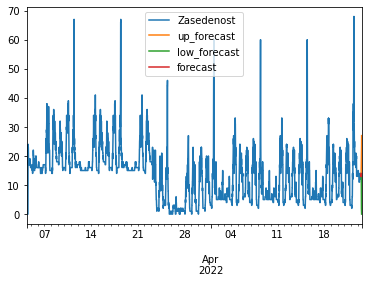

In [17]:
prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0])
# Print the details of the best model
print(model)

# point forecasts dataframe
forecasts_df = prediction.forecast

# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

# TODO: Predict on a larger test set
